# Phase 5: Hypothesis Testing

This notebook covers three behavioral hypotheses using statistical thresholds:
1. **Recovery vs. Inertia**: Do "Rest Days" (low work/study, high distraction) precede "Deep Work Days" (high work/study, low distraction)?
2. **Busy vs. Productive**: Can statistical thresholds distinguish between "High-Volume / Low-Focus" (Busywork) and "High-Volume / High-Focus" (Flow State)?
3. **Weekend Bleed**: Do Work/Study profiles (based on thresholds) intrude into weekends, and is this associated with lower mood?

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
import os
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create figures directory for paper
os.makedirs('figures', exist_ok=True)
print("Figures directory created/verified. All figures will be saved to 'figures/' folder.")

Figures directory created/verified. All figures will be saved to 'figures/' folder.


## Load Cleaned Data

In [32]:
# Load cleaned data
df = pd.read_csv('data/cleaned_data.csv')

# Strip whitespace from column names (common issue with CSV files)
df.columns = df.columns.str.strip()

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure Is_Weekend column exists
if 'Is_Weekend' not in df.columns:
    df['Is_Weekend'] = df['Date'].dt.dayofweek.isin([5, 6])  # Saturday=5, Sunday=6

# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df)} days of data")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nWeekend days: {df['Is_Weekend'].sum()}")
print(f"Weekday days: {(~df['Is_Weekend']).sum()}")

Loaded 89 days of data
Date range: 2025-11-19 00:00:00 to 2026-02-15 00:00:00

Weekend days: 26
Weekday days: 63


In [33]:
# Define Rest Days using thresholds: low work/study, high distraction
rest_threshold_work = df['Work_Hours'].median()
rest_threshold_study = df['Study_Hours'].median()
rest_threshold_distraction = df['Distraction_Time_Mins'].median()

df['Rest_Day'] = (df['Work_Hours'] < rest_threshold_work) & \
                 (df['Study_Hours'] < rest_threshold_study) & \
                 (df['Distraction_Time_Mins'] > rest_threshold_distraction)

# Define Deep Work Days: high work/study, low distraction
# Using median thresholds (more lenient) to capture recovery transitions
# deep_work_threshold = (df['Work_Hours'] + df['Study_Hours']).quantile(0.75)
# low_distraction_threshold = df['Distraction_Time_Mins'].quantile(0.25)

deep_work_threshold = (df['Work_Hours'] + df['Study_Hours']).median()
low_distraction_threshold = df['Distraction_Time_Mins'].median()

df['Deep_Work_Day'] = ((df['Work_Hours'] + df['Study_Hours']) > deep_work_threshold) & \
                      (df['Distraction_Time_Mins'] < low_distraction_threshold)

# Find days in Rest Profile
rest_days = df[df['Rest_Day']].copy()

# For each rest day, check the next day's cluster
transitions = []

for idx, row in rest_days.iterrows():
    if idx < len(df) - 1:  # Make sure there's a next day
        next_day_rest = df.loc[idx + 1, 'Rest_Day']
        next_day_deep_work = df.loc[idx + 1, 'Deep_Work_Day']
        transitions.append({
            'rest_date': row['Date'],
            'next_date': df.loc[idx + 1, 'Date'],
            'next_day_rest': next_day_rest,
            'next_day_deep_work': next_day_deep_work,
            'transition_type': 'Rest → Deep Work' if next_day_deep_work 
                            else ('Rest → Low Performance' if next_day_rest 
                                  else 'Rest → Other')
        })

transitions_df = pd.DataFrame(transitions)

print(f"Total Rest Profile days: {len(rest_days)}")
print(f"Days with next day data: {len(transitions_df)}")
print("\nTransition counts:")
print(transitions_df['transition_type'].value_counts())

# Calculate proportions
if len(transitions_df) > 0:
    rest_to_deep_work = transitions_df['next_day_deep_work'].sum()
    rest_to_low_perf = transitions_df['next_day_rest'].sum()
    rest_to_other = len(transitions_df) - rest_to_deep_work - rest_to_low_perf
    
    print("\nTransition Proportions:")
    print(f"  Rest → Deep Work: {rest_to_deep_work}/{len(transitions_df)} ({rest_to_deep_work/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Low Performance (Rest again): {rest_to_low_perf}/{len(transitions_df)} ({rest_to_low_perf/len(transitions_df)*100:.1f}%)")
    print(f"  Rest → Other: {rest_to_other}/{len(transitions_df)} ({rest_to_other/len(transitions_df)*100:.1f}%)")
    
    # Diagnostic: Analyze "Rest → Other" transitions
    if rest_to_other > 0:
        print("\n=== DIAGNOSTIC: Rest → Other Transitions ===\n")
        print(f"Thresholds: Work+Study > {deep_work_threshold:.2f}, Distraction < {low_distraction_threshold:.2f}\n")
        print("Actual characteristics of Rest → Other days:")
        other_transitions = transitions_df[transitions_df["transition_type"] == "Rest → Other"]
        for _, trans in other_transitions.iterrows():
            next_date = trans["next_date"]
            next_day_data = df[df["Date"] == next_date].iloc[0]
            work_study = next_day_data["Work_Hours"] + next_day_data["Study_Hours"]
            distraction = next_day_data["Distraction_Time_Mins"]
            print(f"  {next_date.strftime('%Y-%m-%d')}: Work+Study={work_study:.2f} (threshold: {deep_work_threshold:.2f}), "
                  f"Distraction={distraction:.2f} (threshold: {low_distraction_threshold:.2f})")
        # Summary statistics
        other_dates = [trans["next_date"] for _, trans in other_transitions.iterrows()]
        other_data = df[df["Date"].isin(other_dates)]
        print(f"\nSummary Statistics for Rest → Other days:")
        print(f"  Avg Work+Study: {(other_data['Work_Hours'] + other_data['Study_Hours']).mean():.2f} (median threshold: {deep_work_threshold:.2f})")
        print(f"  Avg Distraction: {other_data['Distraction_Time_Mins'].mean():.2f} (median threshold: {low_distraction_threshold:.2f})")
        print(f"  Work+Study > threshold: {((other_data['Work_Hours'] + other_data['Study_Hours']) > deep_work_threshold).sum()}/{len(other_data)} days")
        print(f"  Distraction < threshold: {(other_data['Distraction_Time_Mins'] < low_distraction_threshold).sum()}/{len(other_data)} days")


Total Rest Profile days: 9
Days with next day data: 9

Transition counts:
transition_type
Rest → Other              5
Rest → Low Performance    4
Name: count, dtype: int64

Transition Proportions:
  Rest → Deep Work: 0/9 (0.0%)
  Rest → Low Performance (Rest again): 4/9 (44.4%)
  Rest → Other: 5/9 (55.6%)

=== DIAGNOSTIC: Rest → Other Transitions ===

Thresholds: Work+Study > 10.58, Distraction < 240.00

Actual characteristics of Rest → Other days:
  2025-12-28: Work+Study=5.83 (threshold: 10.58), Distraction=210.00 (threshold: 240.00)
  2025-12-31: Work+Study=4.70 (threshold: 10.58), Distraction=500.00 (threshold: 240.00)
  2026-01-03: Work+Study=7.60 (threshold: 10.58), Distraction=350.00 (threshold: 240.00)
  2026-01-18: Work+Study=6.50 (threshold: 10.58), Distraction=300.00 (threshold: 240.00)
  2026-01-27: Work+Study=10.10 (threshold: 10.58), Distraction=180.00 (threshold: 240.00)

Summary Statistics for Rest → Other days:
  Avg Work+Study: 6.95 (median threshold: 10.58)
  Avg Dis

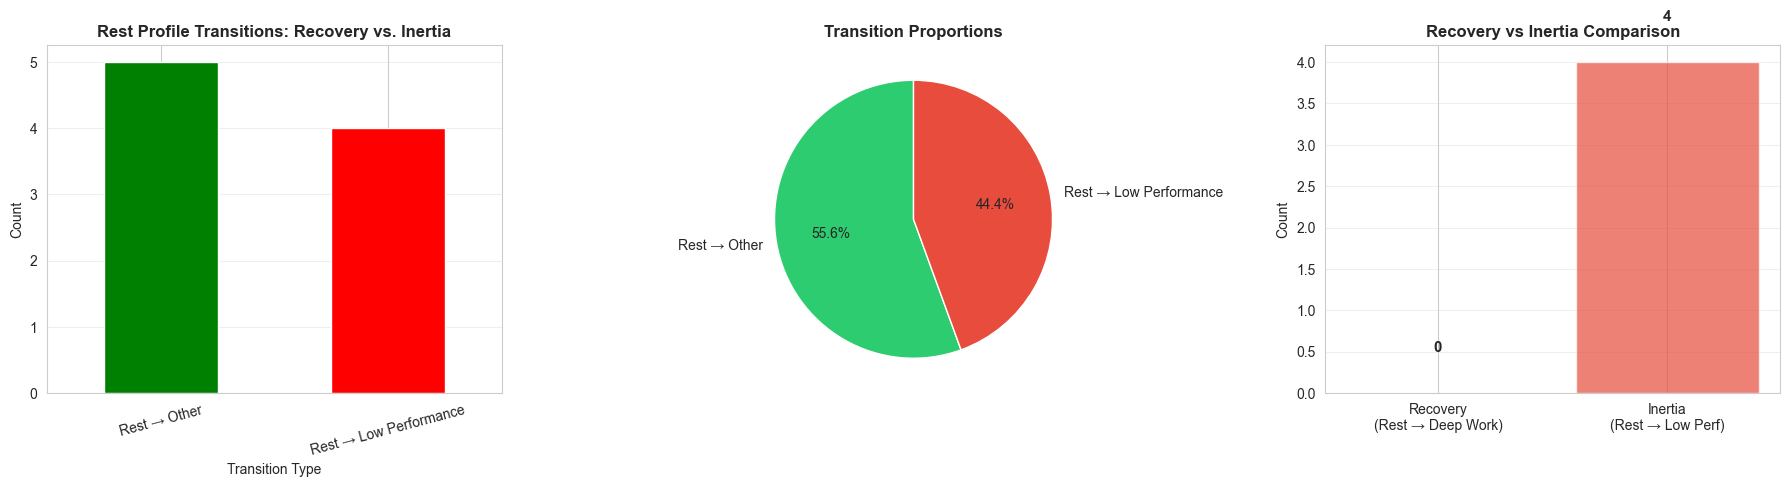

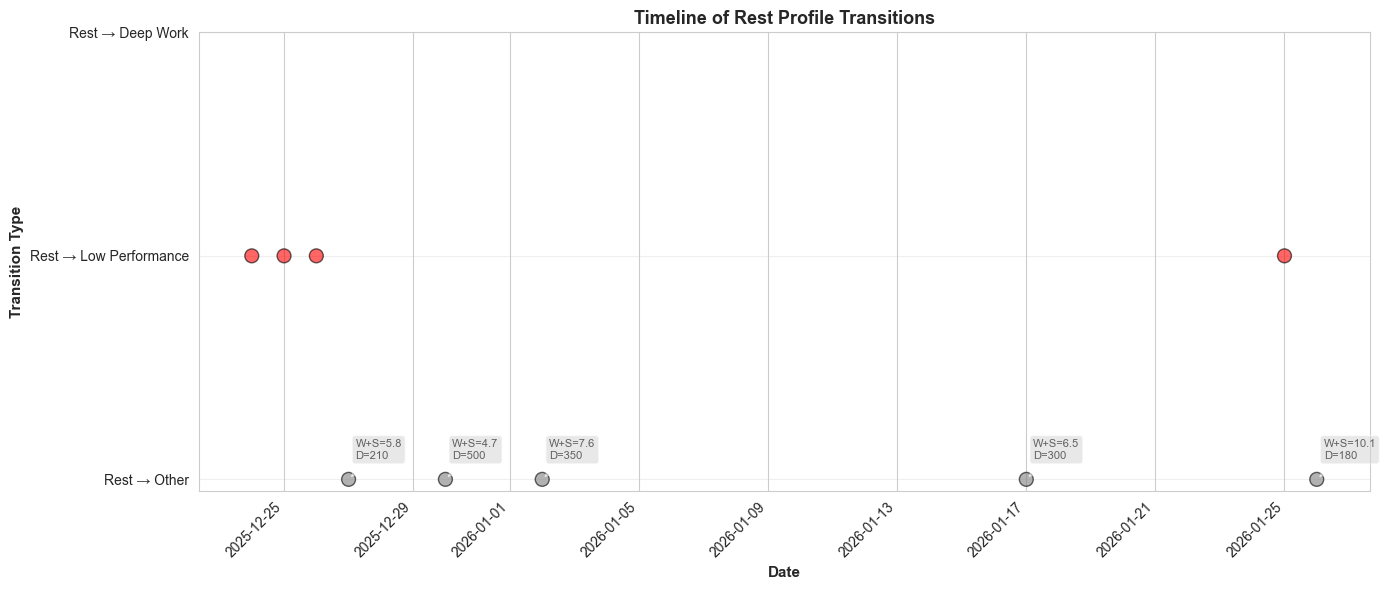

In [34]:
# Visualize transitions - Multiple Figures for Panel Presentation
transition_counts = transitions_df['transition_type'].value_counts()

# Figure 1: Multiple subplots showing different views
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Bar Chart
transition_counts.plot(kind='bar', color=['green', 'red', 'gray'], ax=axes[0])
axes[0].set_title('Rest Profile Transitions: Recovery vs. Inertia', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Transition Type', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Subplot 2: Pie Chart showing proportions
colors_pie = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[1].pie(transition_counts.values, labels=transition_counts.index, autopct='%1.1f%%', 
             colors=colors_pie, startangle=90)
axes[1].set_title('Transition Proportions', fontsize=12, fontweight='bold')

# Subplot 3: Stacked Bar Chart (Recovery vs Inertia)
recovery_inertia = {
    'Recovery\n(Rest → Deep Work)': rest_to_deep_work,
    'Inertia\n(Rest → Low Perf)': rest_to_low_perf
}
axes[2].bar(recovery_inertia.keys(), recovery_inertia.values(), 
            color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[2].set_title('Recovery vs Inertia Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)
for j, (key, val) in enumerate(recovery_inertia.items()):
    axes[2].text(j, val + 0.5, str(val), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('figures/fig6_rest_transitions.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Transition Timeline
if len(transitions_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    transition_dates = transitions_df['rest_date'].values
    transition_types = transitions_df['transition_type'].values
    
    # Map transition types to y-positions
    type_map = {
        'Rest → Deep Work': 2,
        'Rest → Low Performance': 1,
        'Rest → Other': 0
    }
    y_positions = [type_map[t] for t in transition_types]
    
    # Color map
    color_map = {
        'Rest → Deep Work': 'green',
        'Rest → Low Performance': 'red',
        'Rest → Other': 'gray'
    }
    colors = [color_map[t] for t in transition_types]
    
    # Plot timeline
    ax.scatter(transition_dates, y_positions, c=colors, s=100, alpha=0.6, edgecolors='black', linewidth=1)
    
    # Add annotations for Rest → Other transitions showing actual values
    for idx, row in transitions_df.iterrows():
        if row["transition_type"] == "Rest → Other":
            rest_date = row["rest_date"]
            next_date = row["next_date"]
            next_day_data = df[df["Date"] == next_date].iloc[0]
            work_study = next_day_data["Work_Hours"] + next_day_data["Study_Hours"]
            distraction = next_day_data["Distraction_Time_Mins"]
            # Add annotation text
            ax.annotate(f"W+S={work_study:.1f}\nD={distraction:.0f}",
                        xy=(rest_date, type_map["Rest → Other"]),
                        xytext=(5, 15), textcoords="offset points",
                        fontsize=8, alpha=0.7,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5),
                        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", alpha=0.5))
    
    # Add labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Rest → Other', 'Rest → Low Performance', 'Rest → Deep Work'])
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Transition Type', fontsize=11, fontweight='bold')
    ax.set_title('Timeline of Rest Profile Transitions', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('figures/fig7_transition_proportions.png', dpi=300, bbox_inches='tight')
    plt.show()



## Hypothesis 5.2: Busy vs. Productive Distinction

**Hypothesis**: Can distinguish between "High-Volume / Low-Focus" days (Busywork) and "High-Volume / High-Focus" days (Flow State) based on the ratio of Work_Hours to Distraction_Time?

In [35]:
# Compute Work_Hours to Distraction_Time ratio
# Convert Distraction_Time_Mins to hours for ratio
df['Work_Distraction_Ratio'] = df['Work_Hours'] / (df['Distraction_Time_Mins'] / 60 + 0.001)  # Add small value to avoid division by zero

# Define high-volume days (top 50% of Work_Hours)
work_threshold = df['Work_Hours'].median()
df['High_Volume'] = df['Work_Hours'] >= work_threshold

# Define high-focus days (top 50% of Focus_Rating)
focus_threshold = df['Focus_Rating'].median()
df['High_Focus'] = df['Focus_Rating'] >= focus_threshold

# Categorize days
df['Productivity_Type'] = 'Low Volume'
df.loc[df['High_Volume'] & ~df['High_Focus'], 'Productivity_Type'] = 'Busywork (High Volume, Low Focus)'
df.loc[df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Flow State (High Volume, High Focus)'
df.loc[~df['High_Volume'] & df['High_Focus'], 'Productivity_Type'] = 'Low Volume, High Focus'

print("Productivity Type Distribution:")
print(df['Productivity_Type'].value_counts())

print("\nProductivity Type Distribution:")
print(df['Productivity_Type'].value_counts())
print(f"\nTotal days: {len(df)}")

Productivity Type Distribution:
Productivity_Type
Flow State (High Volume, High Focus)    32
Low Volume, High Focus                  29
Low Volume                              15
Busywork (High Volume, Low Focus)       13
Name: count, dtype: int64

Productivity Type Distribution:
Productivity_Type
Flow State (High Volume, High Focus)    32
Low Volume, High Focus                  29
Low Volume                              15
Busywork (High Volume, Low Focus)       13
Name: count, dtype: int64

Total days: 89


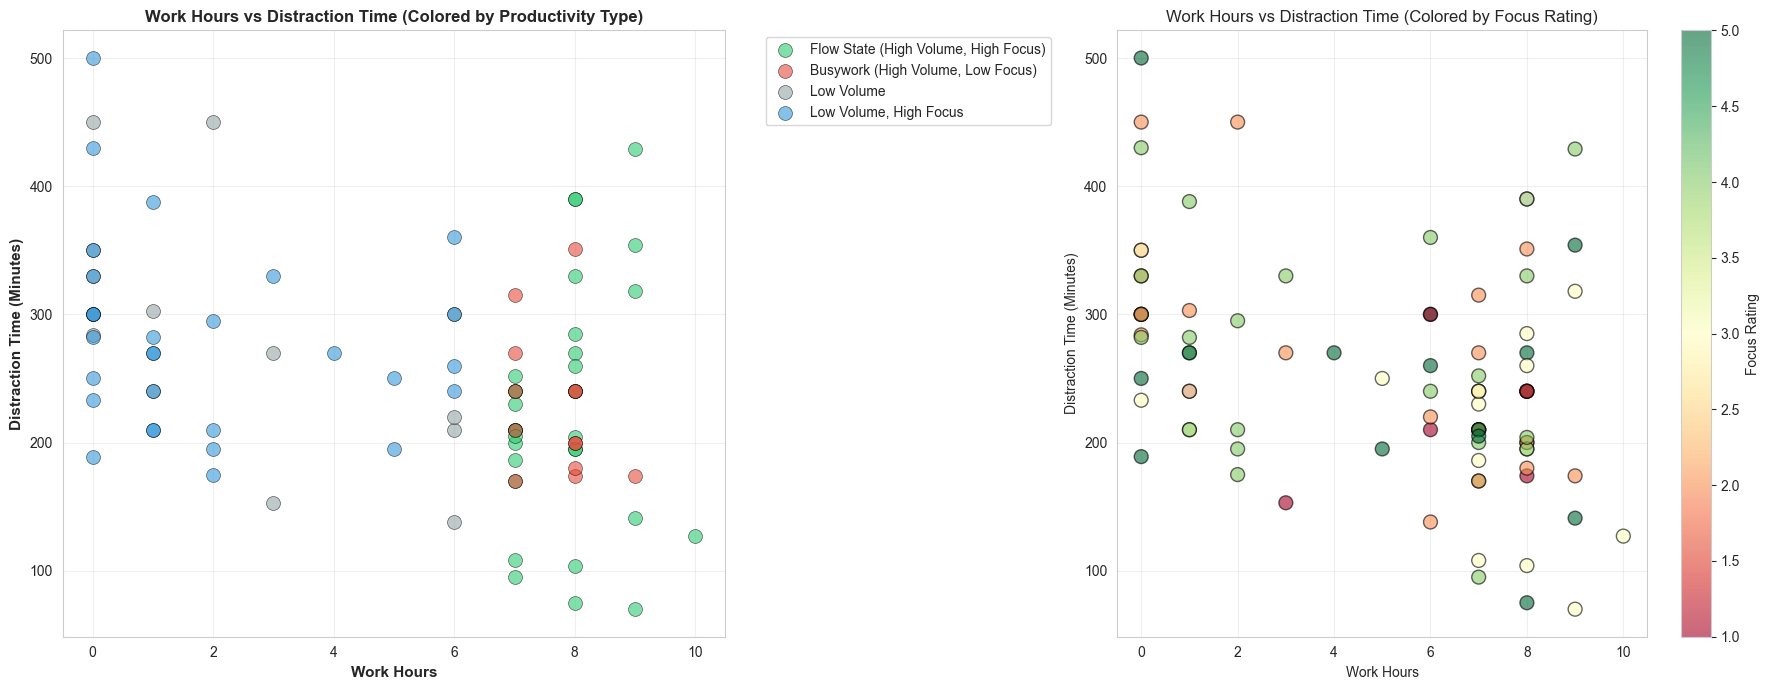

In [36]:
# Visualize Work_Hours vs Distraction_Time_Mins, colored by Productivity_Type and Focus_Rating
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by Productivity Type (Busywork vs Flow State)
# Plot 1: Colored by Productivity Type (Busywork vs Flow State)
productivity_types = df['Productivity_Type'].unique()
colors_map = {'Flow State (High Volume, High Focus)': '#2ecc71',
              'Busywork (High Volume, Low Focus)': '#e74c3c',
              'Low Volume, High Focus': '#3498db',
              'Low Volume': '#95a5a6'}

for ptype in productivity_types:
    mask = df['Productivity_Type'] == ptype
    axes[0].scatter(df[mask]['Work_Hours'], df[mask]['Distraction_Time_Mins'],
                   label=ptype, color=colors_map.get(ptype, 'gray'),
                   s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Work Hours', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Distraction Time (Minutes)', fontsize=11, fontweight='bold')
axes[0].set_title('Work Hours vs Distraction Time (Colored by Productivity Type)', fontsize=12, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].grid(True, alpha=0.3)

# Plot 2: Colored by Focus_Rating
scatter2 = axes[1].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                          c=df['Focus_Rating'], cmap='RdYlGn', 
                          s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('Work Hours')
axes[1].set_ylabel('Distraction Time (Minutes)')
axes[1].set_title('Work Hours vs Distraction Time (Colored by Focus Rating)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Focus Rating')

plt.tight_layout()
plt.show()

In [37]:
# Define weekend mood variables for summary (if not already defined)
if 'Weekend_Bleed' in df.columns and 'Work_Study_Profile' in df.columns:
    weekend_bleed_mood = df[df['Weekend_Bleed']]['Mood_Rating']
    weekend_rest_mood = df[df['Is_Weekend'] & ~df['Work_Study_Profile']]['Mood_Rating']
else:
    weekend_bleed_mood = pd.Series()
    weekend_rest_mood = pd.Series()

In [38]:
# Analyze if clusters naturally separate Busywork from Flow State
high_volume_days = df[df['High_Volume']].copy()

print("High-Volume Days Analysis:")
print("="*60)
print(f"Total high-volume days: {len(high_volume_days)}")
print("\nProductivity Type Distribution (High-Volume Days):")
print(high_volume_days['Productivity_Type'].value_counts())

print("\nBusywork vs Flow State Breakdown:")
busywork_count = len(high_volume_days[high_volume_days['Productivity_Type'] == 'Busywork (High Volume, Low Focus)'])
flow_count = len(high_volume_days[high_volume_days['Productivity_Type'] == 'Flow State (High Volume, High Focus)'])
total = busywork_count + flow_count

if total > 0:
    print(f"\nBusywork: {busywork_count}/{total} ({busywork_count/total*100:.1f}%)")
    print(f"Flow State: {flow_count}/{total} ({flow_count/total*100:.1f}%)")
    
    # Statistical test: t-test for Focus_Rating between Busywork and Flow State
    busywork_focus = high_volume_days[high_volume_days['Productivity_Type'] == 'Busywork (High Volume, Low Focus)']['Focus_Rating']
    flow_focus = high_volume_days[high_volume_days['Productivity_Type'] == 'Flow State (High Volume, High Focus)']['Focus_Rating']
    
    if len(busywork_focus) > 0 and len(flow_focus) > 0:
        t_stat, p_value = stats.ttest_ind(busywork_focus, flow_focus)
        print(f"\nIndependent samples t-test (Focus_Rating):")
        print(f"  Busywork mean Focus: {busywork_focus.mean():.2f}")
        print(f"  Flow State mean Focus: {flow_focus.mean():.2f}")
        print(f"  t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
        
        # Cohen's d (effect size)
        n1, n2 = len(busywork_focus), len(flow_focus)
        pooled_std = np.sqrt(((n1-1)*busywork_focus.var() + (n2-1)*flow_focus.var()) / (n1 + n2 - 2))
        cohens_d = (flow_focus.mean() - busywork_focus.mean()) / pooled_std
        print(f"  Cohen's d: {cohens_d:.2f}")

High-Volume Days Analysis:
Total high-volume days: 45

Productivity Type Distribution (High-Volume Days):
Productivity_Type
Flow State (High Volume, High Focus)    32
Busywork (High Volume, Low Focus)       13
Name: count, dtype: int64

Busywork vs Flow State Breakdown:

Busywork: 13/45 (28.9%)
Flow State: 32/45 (71.1%)

Independent samples t-test (Focus_Rating):
  Busywork mean Focus: 1.85
  Flow State mean Focus: 3.84
  t-statistic: -8.508, p-value: 0.0000
  Cohen's d: 2.80


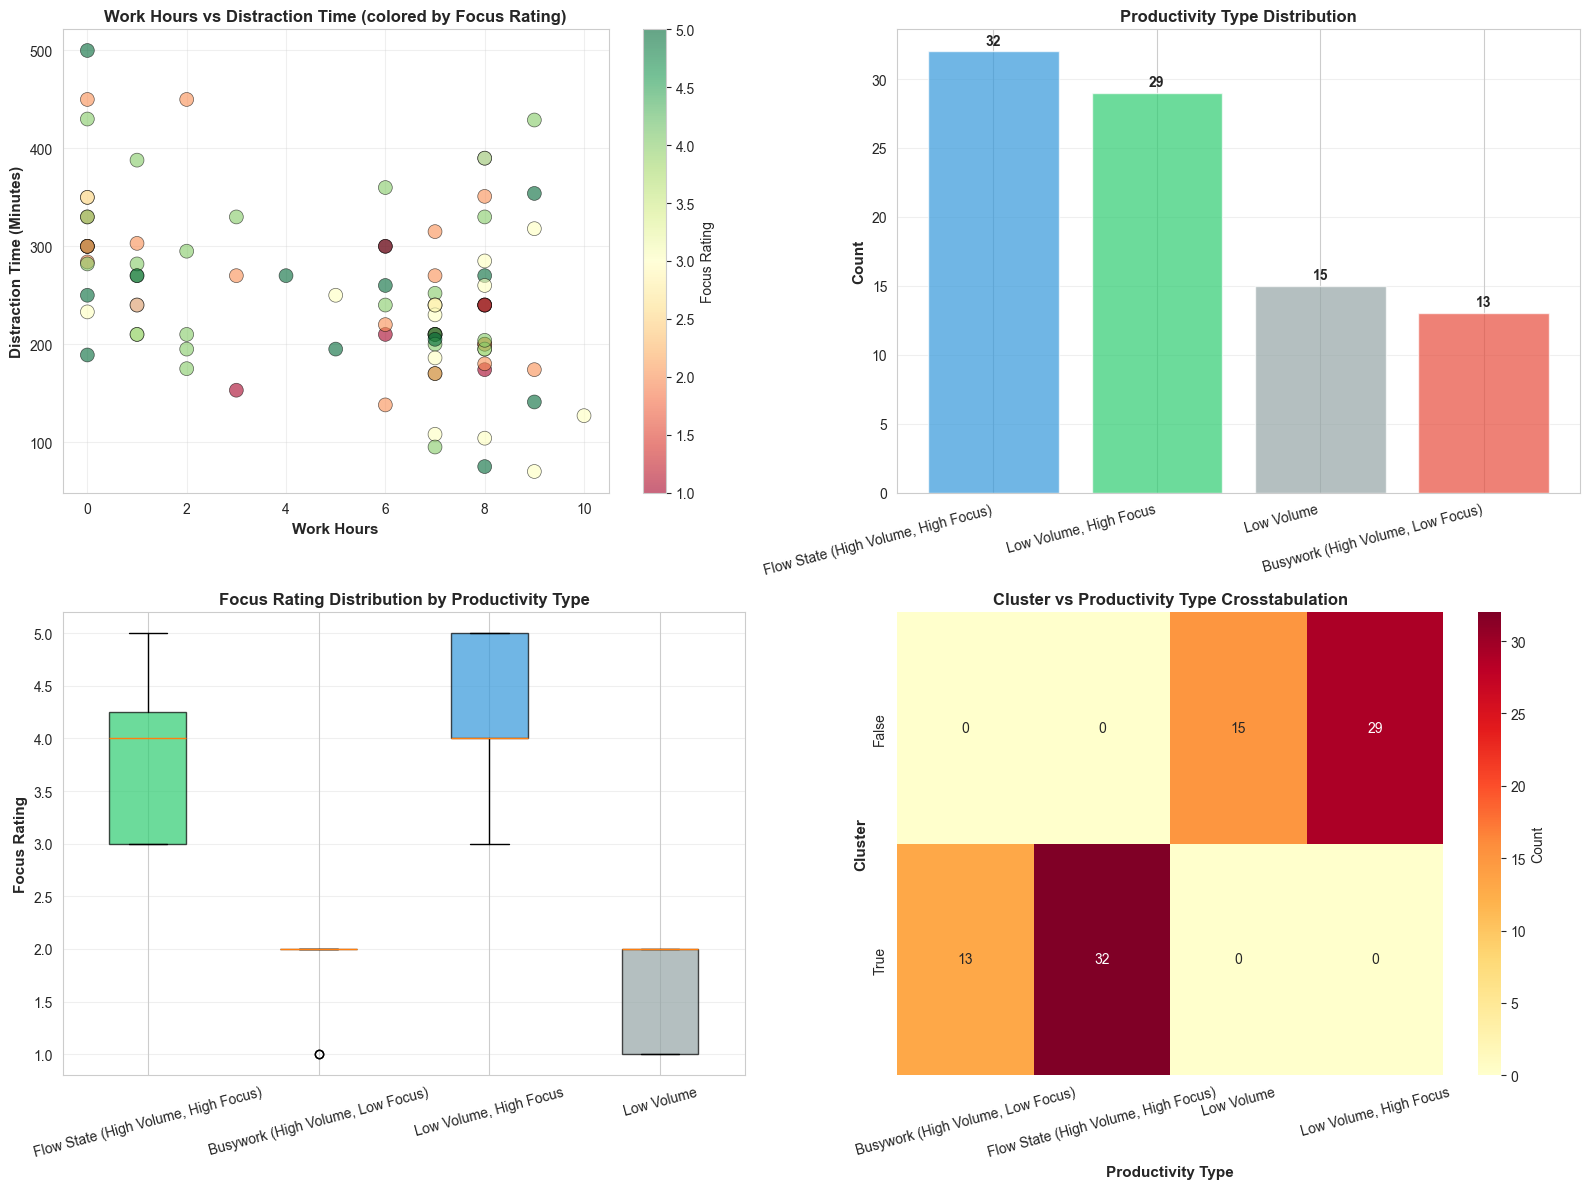

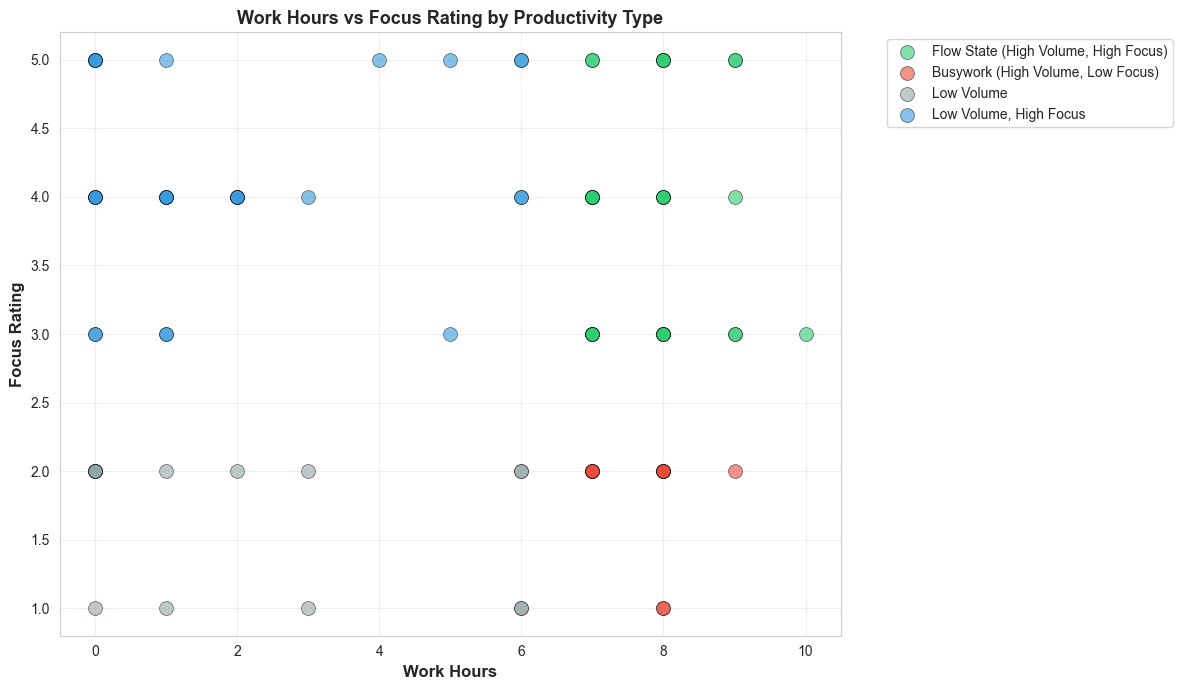

In [39]:
# Visualizations for Hypothesis 5.2: Busy vs. Productive
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Figure 1: Scatter plot - Work_Hours vs Distraction_Time colored by Focus_Rating
scatter = axes[0, 0].scatter(df['Work_Hours'], df['Distraction_Time_Mins'], 
                              c=df['Focus_Rating'], cmap='RdYlGn', 
                              s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Work Hours', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Distraction Time (Minutes)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Work Hours vs Distraction Time (colored by Focus Rating)', 
                      fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Focus Rating')

# Figure 2: Productivity Type Distribution
productivity_counts = df['Productivity_Type'].value_counts()
axes[0, 1].bar(range(len(productivity_counts)), productivity_counts.values, 
               color=['#3498db', '#2ecc71', '#95a5a6', '#e74c3c'], alpha=0.7)
axes[0, 1].set_xticks(range(len(productivity_counts)))
axes[0, 1].set_xticklabels(productivity_counts.index, rotation=15, ha='right')
axes[0, 1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Productivity Type Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for j, val in enumerate(productivity_counts.values):
    axes[0, 1].text(j, val + 0.5, str(val), ha='center', fontweight='bold')

# Figure 3: Box plot - Focus Rating by Productivity Type
productivity_order = ['Flow State (High Volume, High Focus)', 
                      'Busywork (High Volume, Low Focus)',
                      'Low Volume, High Focus', 
                      'Low Volume']
productivity_data = [df[df['Productivity_Type'] == p]['Focus_Rating'].values 
                     for p in productivity_order if p in df['Productivity_Type'].values]
productivity_labels = [p for p in productivity_order if p in df['Productivity_Type'].values]

bp = axes[1, 0].boxplot(productivity_data, labels=productivity_labels, patch_artist=True)
colors_box = ['#2ecc71', '#e74c3c', '#3498db', '#95a5a6']
for patch, color in zip(bp['boxes'], colors_box[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Focus Rating', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Focus Rating Distribution by Productivity Type', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)

# Figure 4: High Volume vs Productivity Type Crosstabulation Heatmap
if 'Productivity_Type' in df.columns and 'High_Volume' in df.columns:
    crosstab = pd.crosstab(df['High_Volume'], df['Productivity_Type'])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1], 
                cbar_kws={'label': 'Count'})
    axes[1, 1].set_xlabel('Productivity Type', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Cluster', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Cluster vs Productivity Type Crosstabulation', 
                          fontsize=12, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Additional Figure: Work_Hours vs Focus_Rating colored by Productivity Type
fig, ax = plt.subplots(figsize=(12, 7))
productivity_types = df['Productivity_Type'].unique()
colors_map = {'Flow State (High Volume, High Focus)': '#2ecc71',
              'Busywork (High Volume, Low Focus)': '#e74c3c',
              'Low Volume, High Focus': '#3498db',
              'Low Volume': '#95a5a6'}

for ptype in productivity_types:
    mask = df['Productivity_Type'] == ptype
    ax.scatter(df[mask]['Work_Hours'], df[mask]['Focus_Rating'], 
               label=ptype, color=colors_map.get(ptype, 'gray'), 
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Work Hours', fontsize=12, fontweight='bold')
ax.set_ylabel('Focus Rating', fontsize=12, fontweight='bold')
ax.set_title('Work Hours vs Focus Rating by Productivity Type', fontsize=13, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


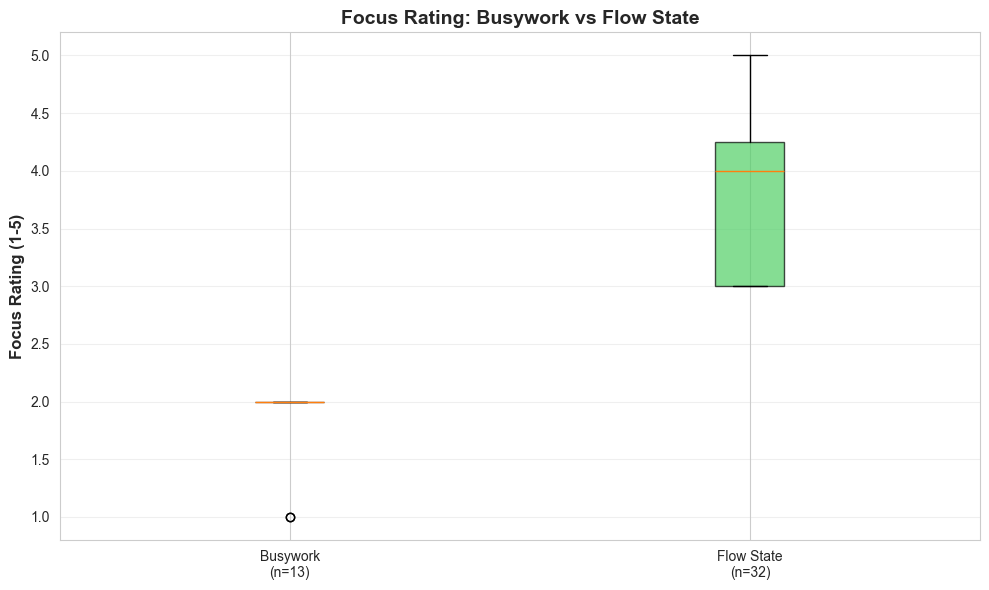

In [40]:
# Figure 8: Busywork vs Flow State Box Plot
fig, ax = plt.subplots(figsize=(10, 6))

high_volume_days = df[df['High_Volume']].copy()
busywork = high_volume_days[high_volume_days['Productivity_Type'] == 'Busywork (High Volume, Low Focus)']
flow_state = high_volume_days[high_volume_days['Productivity_Type'] == 'Flow State (High Volume, High Focus)']

data_to_plot = [busywork['Focus_Rating'], flow_state['Focus_Rating']]
labels = [f'Busywork\n(n={len(busywork)})', f'Flow State\n(n={len(flow_state)})']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['#ff6b6b', '#51cf66']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Focus Rating (1-5)', fontsize=12, fontweight='bold')
ax.set_title('Focus Rating: Busywork vs Flow State', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/fig8_busywork_vs_flow_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Hypothesis 5.3: Weekend Bleed Effect

**Hypothesis**: Do specific habit profiles strictly align with calendar weekends, or do "Work/Study" profiles significantly intrude into weekends, and is this intrusion the strongest predictor of "Low Mood" clusters?

In [41]:
# Define Work/Study Profile using threshold (if not already defined)
if 'Work_Study_Profile' not in df.columns:
    work_study_threshold = (df['Work_Hours'] + df['Study_Hours']).median()
    df['Work_Study_Profile'] = (df['Work_Hours'] + df['Study_Hours']) > work_study_threshold

# Crosstab: Work_Study_Profile vs Is_Weekend
crosstab_weekend = pd.crosstab(df['Work_Study_Profile'], df['Is_Weekend'], 
                               margins=True, 
                               rownames=['Work/Study Profile'], 
                               colnames=['Is Weekend'])

print("Work/Study Profile Distribution by Weekend Status:")
print(crosstab_weekend)

# Calculate proportions
print("\nProportions:")
weekend_props = pd.crosstab(df['Work_Study_Profile'], df['Is_Weekend'], normalize='index') * 100
print(weekend_props.round(2))

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Work_Study_Profile'], df['Is_Weekend']))
print(f"\nChi-square test (Work/Study Profile × Weekend):")
print(f"  Chi-square statistic: {chi2:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Degrees of freedom: {dof}")

# Phi coefficient (effect size for chi-square)
phi = np.sqrt(chi2 / len(df))
print(f"  Phi (φ): {phi:.2f}")

Work/Study Profile Distribution by Weekend Status:
Is Weekend          False  True  All
Work/Study Profile                  
False                  28    17   45
True                   35     9   44
All                    63    26   89

Proportions:
Is_Weekend          False  True 
Work_Study_Profile              
False               62.22  37.78
True                79.55  20.45

Chi-square test (Work/Study Profile × Weekend):
  Chi-square statistic: 2.445
  p-value: 0.1179
  Degrees of freedom: 1
  Phi (φ): 0.17


In [42]:
# Define Work/Study Profile using threshold (already defined earlier, but ensure it exists)
if 'Work_Study_Profile' not in df.columns:
    work_study_threshold = (df['Work_Hours'] + df['Study_Hours']).median()
    df['Work_Study_Profile'] = (df['Work_Hours'] + df['Study_Hours']) > work_study_threshold

# Check if Work/Study profiles appear on weekends
weekend_work_study = df[df['Is_Weekend'] & df['Work_Study_Profile']]

print(f"Total weekend days: {df['Is_Weekend'].sum()}")
print(f"Weekend days with Work/Study profiles: {len(weekend_work_study)}")
print(f"Proportion: {len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%")

print("\nWeekend Work/Study Profile Breakdown:")
print(f"Total weekend days with Work/Study: {len(weekend_work_study)}")
print(f"Average Mood Rating (Weekend + Work/Study): {weekend_work_study['Mood_Rating'].mean():.2f}")

Total weekend days: 26
Weekend days with Work/Study profiles: 9
Proportion: 34.6%

Weekend Work/Study Profile Breakdown:
Total weekend days with Work/Study: 9
Average Mood Rating (Weekend + Work/Study): 3.56


In [43]:
# Define Low Mood (bottom 50% of Mood_Rating)
mood_threshold = df['Mood_Rating'].median()
df['Low_Mood'] = df['Mood_Rating'] < mood_threshold

# Analyze Weekend + Work/Study intrusion vs Low Mood
print("Weekend Bleed Effect Analysis:")
print("="*60)

# Create categories
df['Weekend_Bleed'] = df['Is_Weekend'] & df['Work_Study_Profile']

# Compare mood across different scenarios
scenarios = {
    'Weekday + Work/Study': (~df['Is_Weekend']) & df['Work_Study_Profile'],
    'Weekend + Work/Study (Bleed)': df['Weekend_Bleed'],
    'Weekend + Rest': df['Is_Weekend'] & ~df['Work_Study_Profile'],
    'Weekday + Rest': (~df['Is_Weekend']) & ~df['Work_Study_Profile']
}

print("\nMood Rating by Scenario:")
for scenario_name, mask in scenarios.items():
    scenario_data = df[mask]
    if len(scenario_data) > 0:
        print(f"\n{scenario_name} (n={len(scenario_data)}):")
        print(f"  Mean Mood: {scenario_data['Mood_Rating'].mean():.2f}")
        print(f"  Low Mood Rate: {scenario_data['Low_Mood'].sum()}/{len(scenario_data)} ({scenario_data['Low_Mood'].mean()*100:.1f}%)")

Weekend Bleed Effect Analysis:

Mood Rating by Scenario:

Weekday + Work/Study (n=35):
  Mean Mood: 3.37
  Low Mood Rate: 16/35 (45.7%)

Weekend + Work/Study (Bleed) (n=9):
  Mean Mood: 3.56
  Low Mood Rate: 3/9 (33.3%)

Weekend + Rest (n=17):
  Mean Mood: 3.29
  Low Mood Rate: 10/17 (58.8%)

Weekday + Rest (n=28):
  Mean Mood: 3.46
  Low Mood Rate: 15/28 (53.6%)


# Weekend Bleed Effect

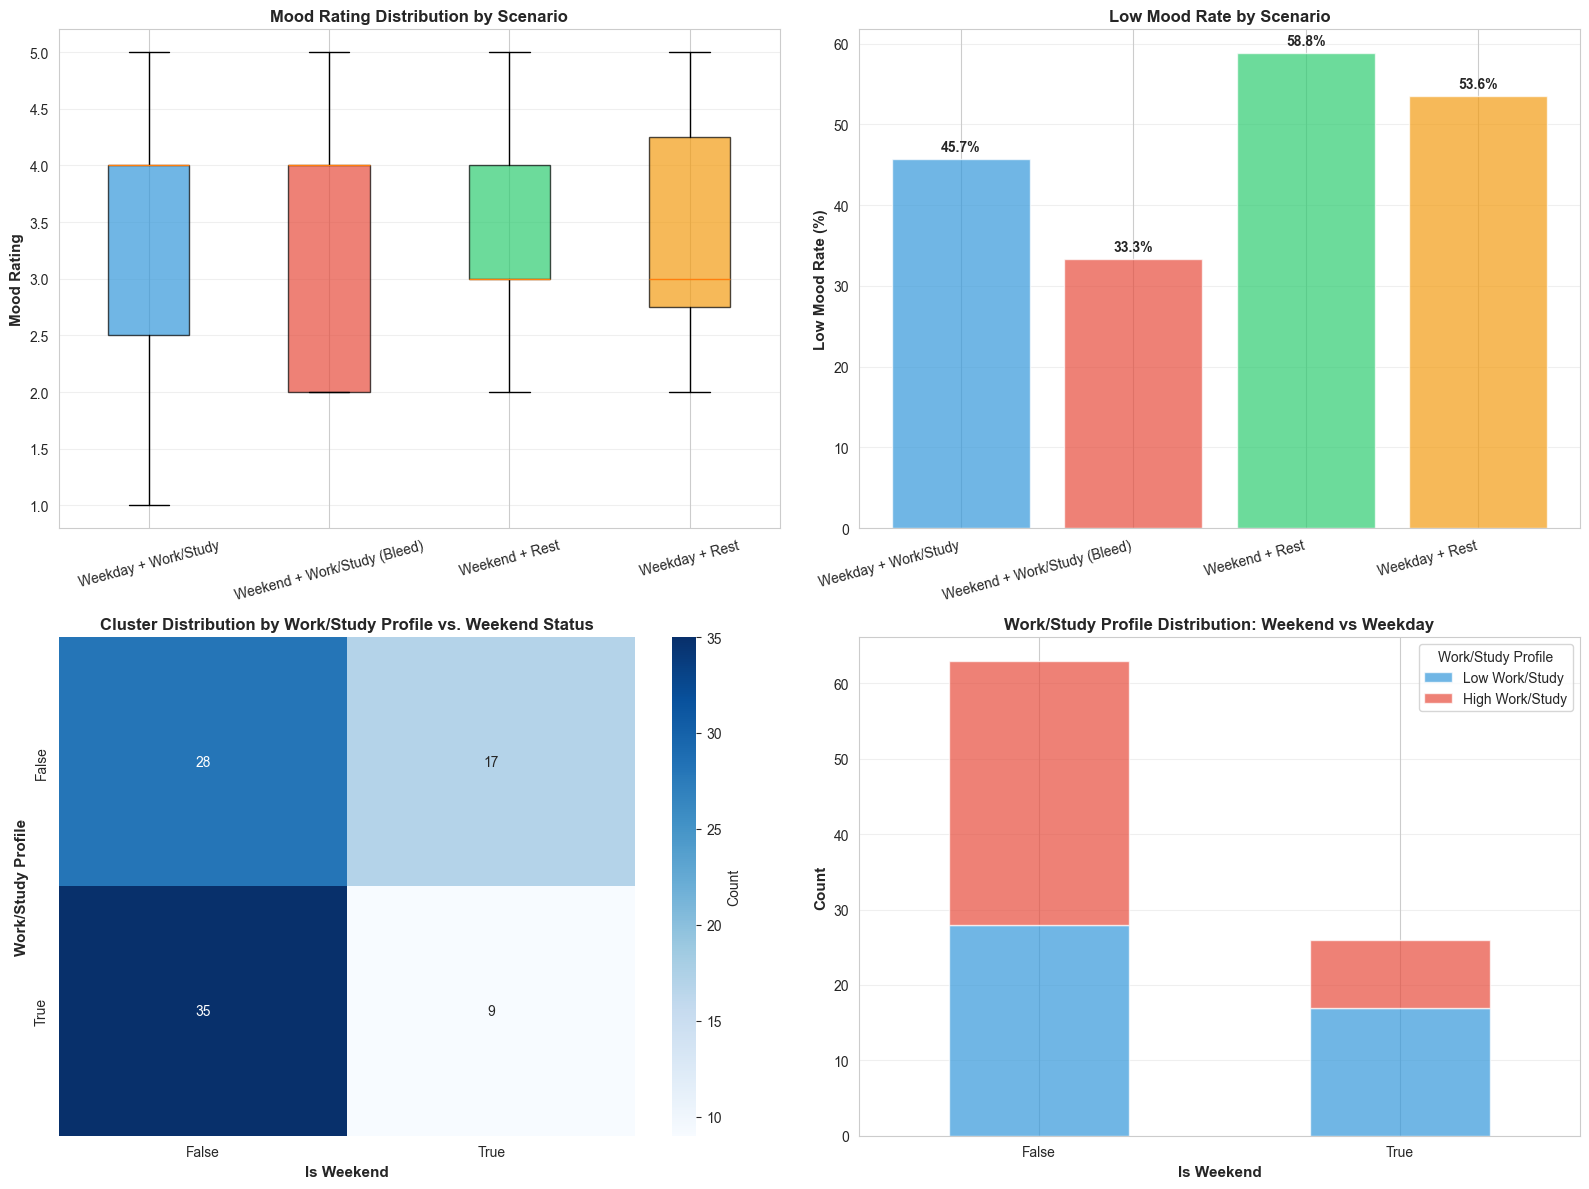

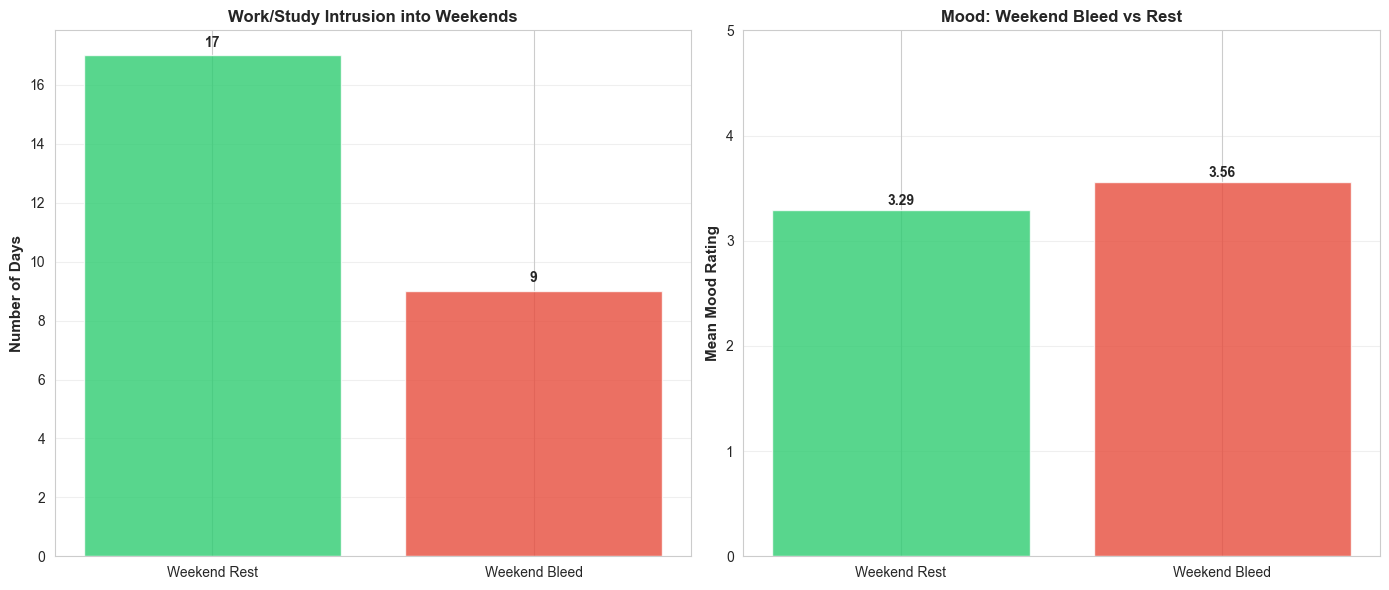

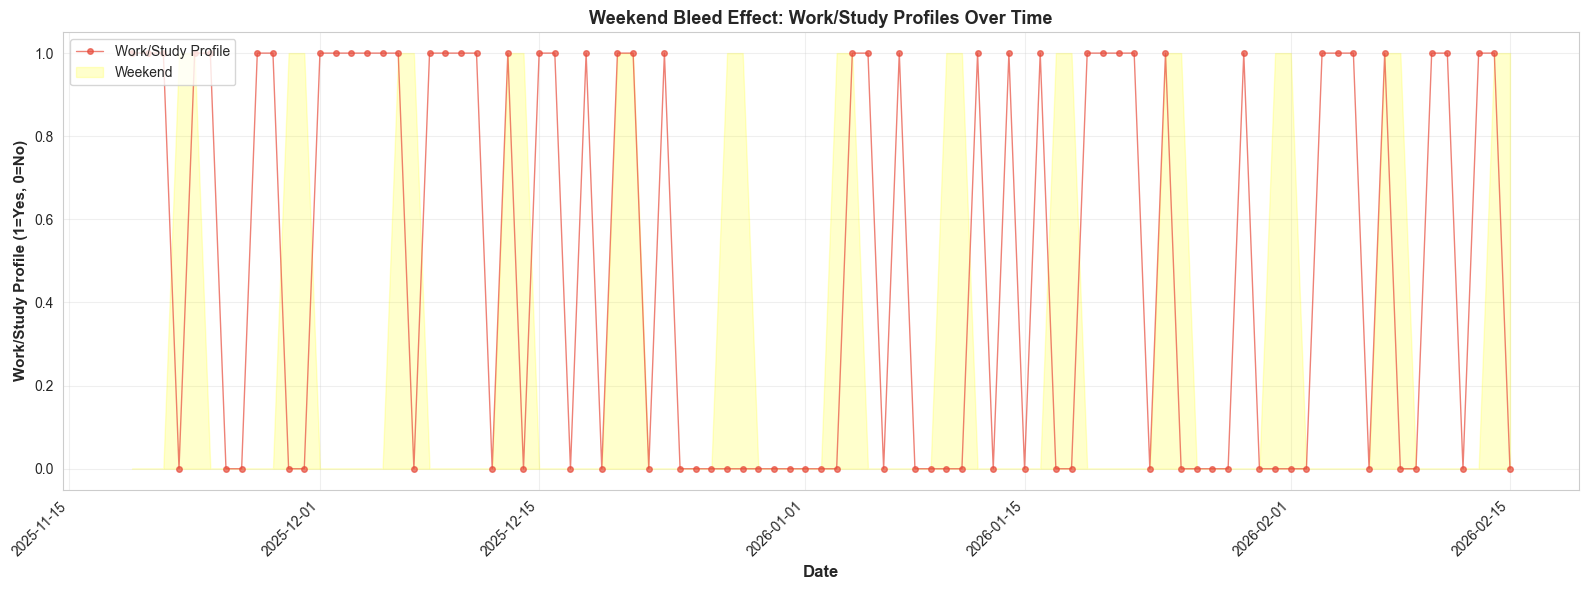

In [44]:
# Enhanced Visualizations for Hypothesis 5.3: Weekend Bleed Effect
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Figure 1: Mood Rating by Scenario (Box Plot)
scenario_moods = [df[mask]['Mood_Rating'].values for mask in scenarios.values()]
bp1 = axes[0, 0].boxplot(scenario_moods, labels=list(scenarios.keys()), patch_artist=True)
colors_scenario = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for patch, color in zip(bp1['boxes'], colors_scenario):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 0].set_ylabel('Mood Rating', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Mood Rating Distribution by Scenario', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(axis='y', alpha=0.3)

# Figure 2: Low Mood Rate by Scenario (Bar Chart)
low_mood_rates = [df[mask]['Low_Mood'].mean() * 100 for mask in scenarios.values()]
bars = axes[0, 1].bar(range(len(scenarios)), low_mood_rates, color=colors_scenario, alpha=0.7)
axes[0, 1].set_xticks(range(len(scenarios)))
axes[0, 1].set_xticklabels(list(scenarios.keys()), rotation=15, ha='right')
axes[0, 1].set_ylabel('Low Mood Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Low Mood Rate by Scenario', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for j, (bar, rate) in enumerate(zip(bars, low_mood_rates)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, rate + 1, 
                    f'{rate:.1f}%', ha='center', fontweight='bold')

# Figure 3: Heatmap - Work/Study Profile vs Weekend Status
crosstab_weekend = pd.crosstab(df['Work_Study_Profile'], df['Is_Weekend'], 
                               rownames=['Work/Study Profile'], colnames=['Is Weekend'])
sns.heatmap(crosstab_weekend, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            cbar_kws={'label': 'Count'})
axes[1, 0].set_title('Cluster Distribution by Work/Study Profile vs. Weekend Status', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Is Weekend', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Work/Study Profile', fontsize=11, fontweight='bold')



# Figure 4: Stacked Bar Chart - Weekend vs Weekday by Work/Study Profile
weekend_profile = pd.crosstab(df['Is_Weekend'], df['Work_Study_Profile'])
weekend_profile.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                     color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 1].set_title('Work/Study Profile Distribution: Weekend vs Weekday', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Is Weekend', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Count', fontsize=11, fontweight='bold') 
axes[1, 1].legend(title='Work/Study Profile', labels=['Low Work/Study', 'High Work/Study'])
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2-Panel Figure: Work/Study Intrusion + Mood (Weekend Bleed vs Rest)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Work/Study intrusion into weekends (bar chart)
weekend_intrusion = pd.DataFrame({
    'Category': ['Weekend Rest', 'Weekend Bleed'],
    'Count': [len(df[df['Is_Weekend'] & ~df['Work_Study_Profile']]), len(df[df['Weekend_Bleed']])]
})
bars = axes[0].bar(weekend_intrusion['Category'], weekend_intrusion['Count'], color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_ylabel('Number of Days', fontsize=11, fontweight='bold')
axes[0].set_title('Work/Study Intrusion into Weekends', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for bar, count in zip(bars, weekend_intrusion['Count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(int(count)), ha='center', fontweight='bold')

# Panel 2: Mood comparison (Weekend Bleed vs Rest)
weekend_bleed_mood = df[df['Weekend_Bleed']]['Mood_Rating']
weekend_rest_mood = df[df['Is_Weekend'] & ~df['Work_Study_Profile']]['Mood_Rating']
mood_means = [weekend_rest_mood.mean(), weekend_bleed_mood.mean()]
mood_labels = ['Weekend Rest', 'Weekend Bleed']
bars2 = axes[1].bar(mood_labels, mood_means, color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1].set_ylabel('Mean Mood Rating', fontsize=11, fontweight='bold')
axes[1].set_title('Mood: Weekend Bleed vs Rest', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 5)
axes[1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, mood_means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/fig9_weekend_bleed.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional Figure: Time Series showing Weekend Bleed Pattern
fig, ax = plt.subplots(figsize=(16, 6))
df_sorted = df.sort_values('Date').copy()
ax.plot(df_sorted['Date'], df_sorted['Work_Study_Profile'].astype(int), 
        marker='o', markersize=4, linestyle='-', linewidth=1, 
        label='Work/Study Profile', color='#e74c3c', alpha=0.7)
ax.fill_between(df_sorted['Date'], 0, df_sorted['Is_Weekend'].astype(int), 
                alpha=0.2, color='yellow', label='Weekend')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Work/Study Profile (1=Yes, 0=No)', fontsize=11, fontweight='bold')
ax.set_title('Weekend Bleed Effect: Work/Study Profiles Over Time', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Summary of Hypothesis Tests

In [45]:
# Compile summary
print("="*80)
print("HYPOTHESIS TESTING SUMMARY")
print("="*80)

print("\n1. Recovery vs. Inertia Hypothesis:")
if len(transitions_df) > 0:
    recovery_rate = rest_to_deep_work / len(transitions_df) * 100
    inertia_rate = rest_to_low_perf / len(transitions_df) * 100
    rest_to_other_rate = (len(transitions_df) - rest_to_deep_work - rest_to_low_perf) / len(transitions_df) * 100
    print(f"   Rest → Deep Work: {recovery_rate:.1f}% ({rest_to_deep_work}/{len(transitions_df)} transitions)")
    print(f"   Rest → Low Performance: {inertia_rate:.1f}% ({rest_to_low_perf}/{len(transitions_df)} transitions)")
    print(f"   Rest → Other: {rest_to_other_rate:.1f}% ({len(transitions_df) - rest_to_deep_work - rest_to_low_perf}/{len(transitions_df)} transitions)")
    print(f"   Conclusion: {'Recovery' if recovery_rate > inertia_rate else 'Inertia'} pattern dominates")
    if recovery_rate == 0:
        print("   Note: No recovery transitions observed under strict criteria")

print("\n2. Busy vs. Productive Distinction:")
print(f"   High-volume days: {len(high_volume_days)}")
if 'Busywork (High Volume, Low Focus)' in df['Productivity_Type'].values:
    busywork_count = (df['Productivity_Type'] == 'Busywork (High Volume, Low Focus)').sum()
    flow_count = (df['Productivity_Type'] == 'Flow State (High Volume, High Focus)').sum()
    print(f"   Busywork days: {busywork_count}")
    print(f"   Flow State days: {flow_count}")
    
    # Statistical test: t-test for Focus_Rating
    busywork_focus = high_volume_days[high_volume_days['Productivity_Type'] == 'Busywork (High Volume, Low Focus)']['Focus_Rating']
    flow_focus = high_volume_days[high_volume_days['Productivity_Type'] == 'Flow State (High Volume, High Focus)']['Focus_Rating']
    
    if len(busywork_focus) > 0 and len(flow_focus) > 0:
        t_stat, p_value = stats.ttest_ind(busywork_focus, flow_focus)
        print(f"\n   Statistical Test (Independent samples t-test):")
        print(f"     Busywork mean Focus: {busywork_focus.mean():.2f}")
        print(f"     Flow State mean Focus: {flow_focus.mean():.2f}")
        print(f"     t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
        n1, n2 = len(busywork_focus), len(flow_focus)
        pooled_std = np.sqrt(((n1-1)*busywork_focus.var() + (n2-1)*flow_focus.var()) / (n1 + n2 - 2))
        cohens_d = (flow_focus.mean() - busywork_focus.mean()) / pooled_std
        print(f"     Cohen's d: {cohens_d:.2f}")
        print(f"     Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

print("\n3. Weekend Bleed Effect:")
print(f"   Weekend days with Work/Study profiles: {len(weekend_work_study)}/{df['Is_Weekend'].sum()} ({len(weekend_work_study)/df['Is_Weekend'].sum()*100:.1f}%)")

# Ensure Weekend_Bleed column exists
if 'Weekend_Bleed' not in df.columns and 'Work_Study_Profile' in df.columns:
    df['Weekend_Bleed'] = df['Is_Weekend'] & df['Work_Study_Profile']

# Calculate mood comparisons
if 'Weekend_Bleed' in df.columns:
    weekend_bleed_mood = df[df['Weekend_Bleed']]['Mood_Rating']
    weekend_rest_mood = df[df['Is_Weekend'] & ~df['Work_Study_Profile']]['Mood_Rating']
else:
    weekend_bleed_mood = pd.Series()
    weekend_rest_mood = pd.Series()

if len(weekend_bleed_mood) > 0 and len(weekend_rest_mood) > 0:
    print(f"   Weekend Bleed Mood: {weekend_bleed_mood.mean():.2f}")
    print(f"   Weekend Rest Mood: {weekend_rest_mood.mean():.2f}")
    print(f"   {'Weekend Bleed' if weekend_bleed_mood.mean() < weekend_rest_mood.mean() else 'No clear'} effect on mood")

# Statistical test: Chi-square test
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Work_Study_Profile'], df['Is_Weekend']))
phi = np.sqrt(chi2 / len(df))
print(f"\n   Statistical Test (Chi-square test):")
print(f"     Chi-square statistic: {chi2:.3f}")
print(f"     p-value: {p_value:.4f}")
print(f"     Degrees of freedom: {dof}")
print(f"     Phi (φ): {phi:.2f}")
print(f"     Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")
print("\n" + "="*80)


HYPOTHESIS TESTING SUMMARY

1. Recovery vs. Inertia Hypothesis:
   Rest → Deep Work: 0.0% (0/9 transitions)
   Rest → Low Performance: 44.4% (4/9 transitions)
   Rest → Other: 55.6% (5/9 transitions)
   Conclusion: Inertia pattern dominates
   Note: No recovery transitions observed under strict criteria

2. Busy vs. Productive Distinction:
   High-volume days: 45
   Busywork days: 13
   Flow State days: 32

   Statistical Test (Independent samples t-test):
     Busywork mean Focus: 1.85
     Flow State mean Focus: 3.84
     t-statistic: -8.508, p-value: 0.0000
     Cohen's d: 2.80
     Significant: Yes (α=0.05)

3. Weekend Bleed Effect:
   Weekend days with Work/Study profiles: 9/26 (34.6%)
   Weekend Bleed Mood: 3.56
   Weekend Rest Mood: 3.29
   No clear effect on mood

   Statistical Test (Chi-square test):
     Chi-square statistic: 2.445
     p-value: 0.1179
     Degrees of freedom: 1
     Phi (φ): 0.17
     Significant: No (α=0.05)



## Save Results

In [46]:
# Save updated dataframe with hypothesis analysis columns
df.to_csv('data/data_with_hypothesis_analysis.csv', index=False)

# Save transitions data
transitions_df.to_csv('data/recovery_inertia_transitions.csv', index=False)

print("Results saved:")
print("- data/data_with_hypothesis_analysis.csv")
print("- data/recovery_inertia_transitions.csv")

Results saved:
- data/data_with_hypothesis_analysis.csv
- data/recovery_inertia_transitions.csv
